In [20]:
%load_ext autoreload
%autoreload 2
import sys, os, torch
from numba import cuda 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sys.path.append("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from src import knockoffs, models, simulations, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Creating Simulation Dataset

In [3]:
n = 20000
p = 30
func_id=1
seed=42

X = simulations.UniformSampler(p=p, low_list=([0]*p), high_list=([1]*p), seed=seed).sample(n=n)
Y, inter_gt, import_gt = simulations.generate_interaction_response(X, func_id)
Y = StandardScaler().fit_transform(Y)
X = StandardScaler().fit_transform(X)

### Generating Knockoffs

In [4]:
X_knockoff = knockoffs.KnockoffGAN(X)
device = cuda.get_current_device()
device.reset()

2023-11-30 00:16:04.716929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46232 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:23:00.0, compute capability: 8.6
2023-11-30 00:16:04.731469: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
100%|██████████| 2000/2000 [01:18<00:00, 25.55it/s]


### Train DeepROCK model

In [5]:
nepochs=100
weight_decay_const=1e-4
batch_size=256
learning_rate=0.01

X_concat = np.concatenate([X, X_knockoff], axis=1)
data_loaders, data_arrs = models.get_torch_loaders(
    X=X_concat, Y=Y, batch_size=batch_size, train_ratio=0.5)

X_concat_train = data_arrs["train"][0]
X_concat_test = data_arrs["test"][0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.DeepROCK(p=p, hidden_dims=[140, 100, 60, 20]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
criterion = torch.nn.MSELoss(reduction="mean")

model, train_losses, val_losses = models.train(model,
    data_loaders=data_loaders, optimizer=optimizer, criterion=criterion, verbose=True,
    nepochs=nepochs, decay_const=weight_decay_const, device=device, 
    early_stopping=False, patience=-1)

starting to train
[epoch 1, total 100] train loss: 0.21717, val loss: 0.11095
[epoch 2, total 100] train loss: 0.08777, val loss: 0.07268
[epoch 3, total 100] train loss: 0.05511, val loss: 0.07430
[epoch 4, total 100] train loss: 0.04079, val loss: 0.03098
[epoch 5, total 100] train loss: 0.02395, val loss: 0.01910
[epoch 6, total 100] train loss: 0.01700, val loss: 0.02667
[epoch 7, total 100] train loss: 0.01996, val loss: 0.01479
[epoch 8, total 100] train loss: 0.01197, val loss: 0.01733
[epoch 9, total 100] train loss: 0.01185, val loss: 0.01118
[epoch 10, total 100] train loss: 0.01059, val loss: 0.02523
[epoch 11, total 100] train loss: 0.01277, val loss: 0.01019
[epoch 12, total 100] train loss: 0.00808, val loss: 0.00798
[epoch 13, total 100] train loss: 0.00644, val loss: 0.00677
[epoch 14, total 100] train loss: 0.00726, val loss: 0.00714
[epoch 15, total 100] train loss: 0.00710, val loss: 0.02520
[epoch 16, total 100] train loss: 0.00919, val loss: 0.00573
[epoch 17, tota

### Detecting Interactions

In [6]:
global_interaction_import = model.global_feature_interactions(calibrate=True)
local_interaction_import = model.local_feature_interactions(X_concat_test, X_concat_train, calibrate=True)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:56<00:00,  1.42s/it]


In [14]:
target_fdr=0.2

global_inter_auc = utils.pairwise_interaction_auc(global_interaction_import, inter_gt)
global_sel_inters, global_knockoff_thres = utils.get_selected_interactions(
    global_interaction_import, p, target_fdr)
global_inter_power = utils.get_interaction_power(global_sel_inters, inter_gt)
global_inter_fdp = utils.get_interaction_fdp(global_sel_inters, inter_gt)
print(f'global_inter_auc={global_inter_auc:.3f}\tglobal_inter_power={global_inter_power:.3f}'
        f'\tglobal_inter_fdp={global_inter_fdp:.3f}')

local_inter_auc = utils.pairwise_interaction_auc(local_interaction_import, inter_gt)
local_sel_inters, local_knockoff_thres = utils.get_selected_interactions(
    local_interaction_import, p, target_fdr)
local_inter_power = utils.get_interaction_power(local_sel_inters, inter_gt)
local_inter_fdp = utils.get_interaction_fdp(local_sel_inters, inter_gt)
print(f'local_inter_auc={local_inter_auc:.3f}\tlocal_inter_power={local_inter_power:.3f}'
        f'\tlocal_inter_fdp={local_inter_fdp:.3f}')

global_inter_auc=0.998	global_inter_power=0.545	global_inter_fdp=0.000
local_inter_auc=1.000	local_inter_power=0.818	local_inter_fdp=0.000


In [18]:
global_feat_inter_df = utils.get_interaction_df(global_interaction_import, p, import_gt, inter_gt)
local_feat_inter_df = utils.get_interaction_df(local_interaction_import, p, import_gt, inter_gt)

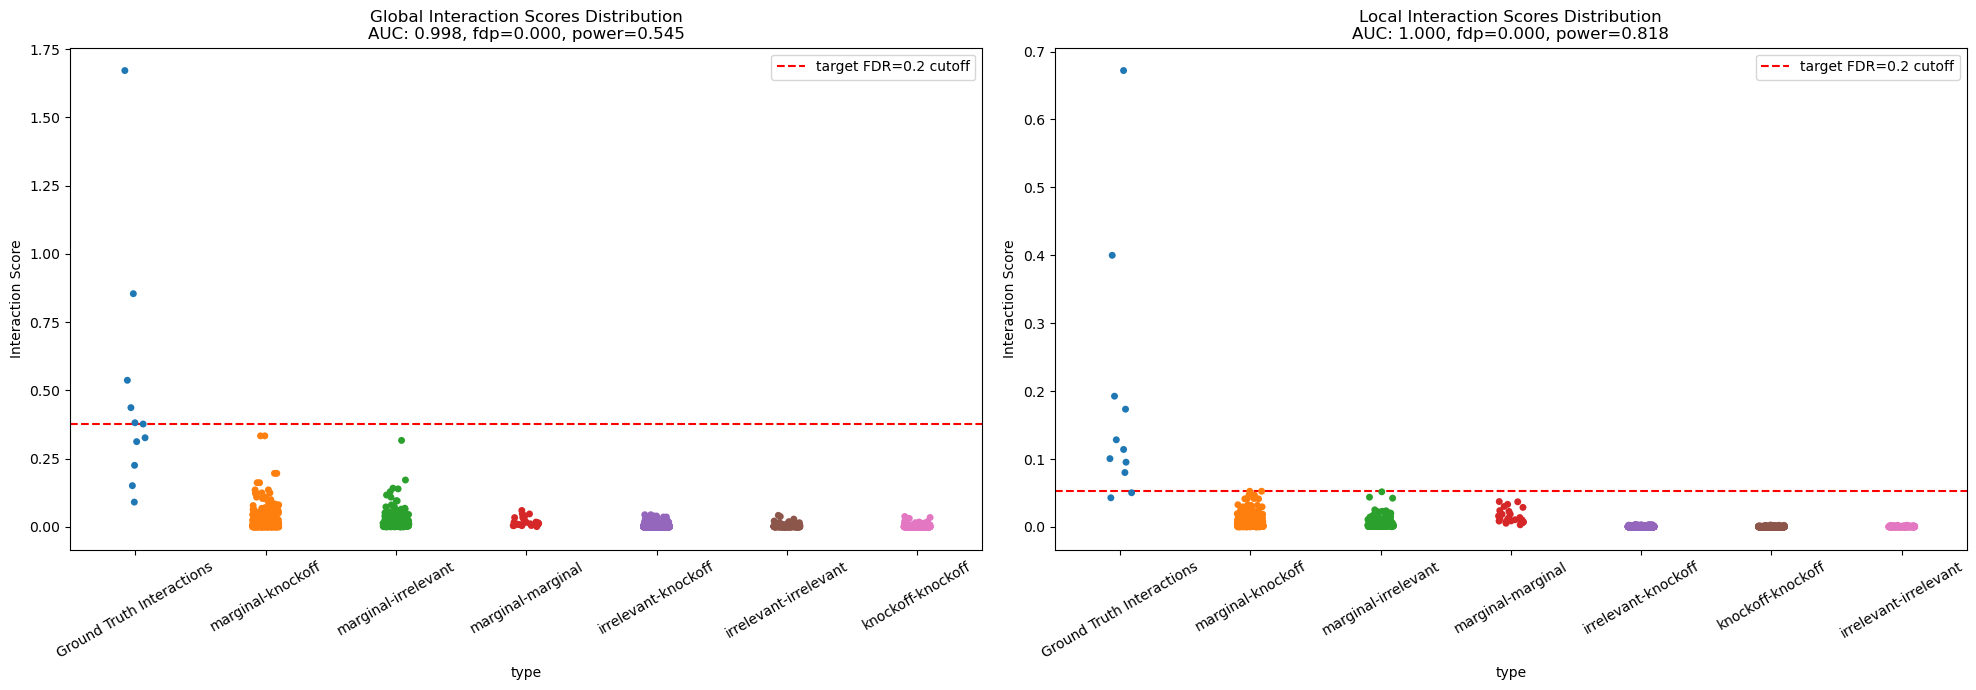

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
sns.stripplot(x="type", y="value", hue="type", data=global_feat_inter_df, legend=False, ax=axes[0])
axes[0].axhline(y=global_knockoff_thres, color="r", linestyle="--", label=f"target FDR={target_fdr} cutoff")
axes[0].set_title(f"Global Interaction Scores Distribution\nAUC: {global_inter_auc:.3f}, "
    f"fdp={global_inter_fdp:.3f}, power={global_inter_power:.3f}")
axes[0].set_ylabel("Interaction Score")
axes[0].tick_params(axis='x', labelrotation=30)
axes[0].legend()
sns.stripplot(x="type", y="value", hue="type", data=local_feat_inter_df, legend=False, ax=axes[1])
axes[1].axhline(y=local_knockoff_thres, color="r", linestyle="--", label=f"target FDR={target_fdr} cutoff")
axes[1].set_title(f"Local Interaction Scores Distribution\nAUC: {local_inter_auc:.3f}, "
    f"fdp={local_inter_fdp:.3f}, power={local_inter_power:.3f}")
axes[1].set_ylabel("Interaction Score")
axes[1].tick_params(axis='x', labelrotation=30)
axes[1].legend()
fig.tight_layout()